### 3) Minibatch Gradient descent

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape)
print('y_test: ',y_test.shape)
print('y_test[0]',y_test[0])

K = len(np.unique(y_train)) # Number of Classes
print('Number of classes: ',K)

x_train:  (50000, 32, 32, 3)
y_test:  (10000, 1)
y_test[0] [3]
Number of classes:  10


In [3]:
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10, 32x32x3=3072
# Din = 784 # MINIST

# Normalize pixel values: numpy works in one datatype(weights,features):float, faster training,
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
#centering the data and making range similar in order to get stable gradients
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

#re-classify the y(label) sets as categorical: onehot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#resize x set into a collection of rows, each row is an image
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

y_train: (50000, 10)
y_test: (10000, 10)
x_train: (50000, 3072)
x_test: (10000, 3072)


In [5]:
#parameters
batch_size = Ntr    #set batchsize to entire trainingset size
iterations = 30
lr = 0.016         #learning rate
lr_decay= 0.9999   #learning rate decay
reg = 1e-7         #regularization parameter
loss_history = []
train_acc_history = []
val_acc_history = []

#fix seed for random number generator
seed = 0
rng = np.random.default_rng(seed=seed)

In [6]:
def accuracy(y_pred,y):
    predclass = np.argmax(y_pred,axis=1)
    realclass = np.argmax(y,axis=1)
    return ( np.sum(predclass==realclass)/realclass.size )

In [7]:
def reg_MSloss(y_pred,y,batchsize,reg,w1):
    return (1./batchsize)* np.square(y_pred-y).sum()  + reg*np.sum( [np.sum(w*w)for w in w1] )

In [8]:
def batching(indexlist , batchsize):
    #returns a list of lists, each list containing indexes of batchsize
    batches = []
    for i in range(round( len(indexlist)/batchsize ) ):
        batches.append(indexlist[i*batchsize:(i+1)*batchsize])
    return batches;

In [12]:
def run2LNN(batchsize=batch_size,iterations=iterations,lr=lr,lr_decay=lr_decay,reg=reg):
    t0 = time.time()
    std=1e-5
    H = 200 # hidden layer number of neurons
    w1 = std*np.random.randn(Din, H)
    b1 = np.zeros(H)
    w2 = std*np.random.randn(H,K)
    b2 = np.zeros(K)

    loss_history = []
    test_losshistory = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        indexlist = np.random.choice(Ntr,batchsize,replace=False)
        rng.shuffle(indexlist)
        batches = batching(indexlist,batchsize)

        for batch_indices in batches:
            x = x_train[batch_indices]*255 #made backprop more prominent
            y = y_train[batch_indices]
        
            # Forward pass
            z = x.dot(w1) + b1
            a = 1./(1 + np.exp(-z)) #sigmoid activation
            y_pred = a.dot(w2) + b2

            dy_pred = (1./batchsize)*2.0*(y_pred-y)
            dw2 = a.T.dot(dy_pred) + reg*w2
            db2 = dy_pred.sum(axis=0)
            
            da = dy_pred.dot(w2.T)
            dz = a*(1-a)*da
            dw1 = x.T.dot(dz) + reg*w1
            db1 = dz.sum(axis=0)

            # Backward pass
            w1 -= lr*dw1
            b1 -= lr*db1
            w2 -= lr*dw2
            b2 -= lr*db2

            lr *= lr_decay

        testz = 255*x_test.dot(w1) + b1 #made backprop more prominent
        testa = 1./(1 + np.exp(-testz)) #sigmoid activation
        testy = testa.dot(w2) + b2

        train_loss = reg_MSloss(y_pred,y,batchsize,reg,[w1,w2]) #regularized mean square loss
        test_loss = reg_MSloss(testy,y_test,10000,reg,[w1,w2])
        loss_history.append(train_loss)
        test_losshistory.append(test_loss)

        train_acc= accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        val_acc=accuracy(testy,y_test)
        val_acc_history.append(val_acc)

        if t%5 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,val_acc))

    t1 = time.time()
    print('time taken = ',(t1-t0)//60,'minutes -', (t1-t0)%60, 'seconds')

    return w1,loss_history,test_losshistory,train_acc_history,val_acc_history

In [17]:
w1,loss_history2,test_losshistory2,train_acc_history2,val_acc_history2 = run2LNN(batchsize=500,iterations=300,lr=0.016,lr_decay=0.999,reg=5e-6)

epoch 0/300: MSloss= 0.999988-- ,test loss= 0.951195--,train accracy= 0.074000--, test accracy= 0.100000
epoch 5/300: MSloss= 1.032627-- ,test loss= 1.011056--,train accracy= 0.106000--, test accracy= 0.101500
epoch 10/300: MSloss= 0.878992-- ,test loss= 0.876935--,train accracy= 0.158000--, test accracy= 0.172700
epoch 15/300: MSloss= 0.853921-- ,test loss= 0.850704--,train accracy= 0.248000--, test accracy= 0.258500
epoch 20/300: MSloss= 0.836887-- ,test loss= 0.849519--,train accracy= 0.258000--, test accracy= 0.205600
epoch 25/300: MSloss= 0.825134-- ,test loss= 0.841982--,train accracy= 0.326000--, test accracy= 0.277300
epoch 30/300: MSloss= 0.854018-- ,test loss= 0.842412--,train accracy= 0.254000--, test accracy= 0.285500
epoch 35/300: MSloss= 0.826952-- ,test loss= 0.834207--,train accracy= 0.342000--, test accracy= 0.275100
epoch 40/300: MSloss= 0.832173-- ,test loss= 0.830641--,train accracy= 0.288000--, test accracy= 0.301500
epoch 45/300: MSloss= 0.821293-- ,test loss= 0.8

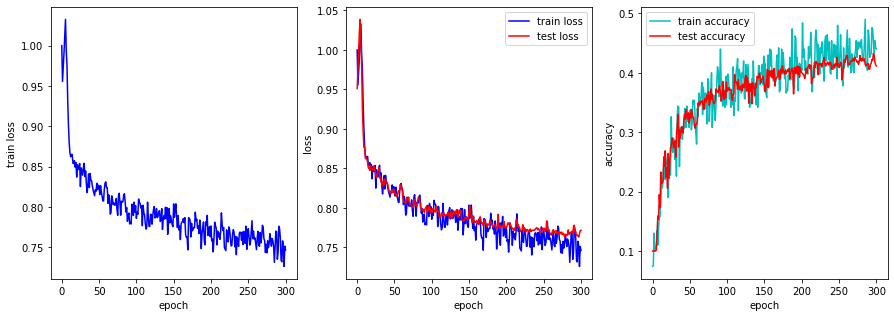

In [18]:
#display Train and testingloss; train and testingaccuracy
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(loss_history2,'b')
ax[0].set_xlabel('epoch') 
ax[0].set_ylabel('train loss') 

ax[1].plot(loss_history2,'b')
ax[1].plot(test_losshistory2,'r')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')  
ax[1].legend(['train loss','test loss'])

ax[2].plot(train_acc_history2,'c')
ax[2].plot(val_acc_history2,'r')
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('accuracy')  
ax[2].legend(['train accuracy','test accuracy']);